# Data Preparation and Exploration
Dataset
This dataset is from Kaggle competition Bike Sharing Demand
Input Features: ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'dayofweek']
Target Feature: ['count']

Objective: You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period (Ref: Kaggle.com)

# Data Exploration
Look at the data field, we see that datetime is a time object and we need to pass parse_dates when we read the csv file, otherwise Pandas will read this field as a string

[Develop a XGBoost model on SageMaker to Forecast Demand](http://tuleblogs.com/blogs/Develop%20a%20XGBoost%20model%20on%20SageMaker%20to%20forecast%20Bike%20Sharing%20Demand.html)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
columns = ['count', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'dayofweek']

In [3]:
pwd

'/Users/medamin/_Projets/_DataScience/DirectOfInformaiton_Project'

In [4]:
df = pd.read_csv('data/train.csv', parse_dates=['datetime'])
df_test = pd.read_csv('data/test.csv', parse_dates=['datetime'])

In [5]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [16]:
df.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [17]:
# convert datetime to numeric for training.
# Let's extract key features into separate numeric columns
def add_features(df):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['dayofweek'] = df['datetime'].dt.dayofweek

In [18]:
add_features(df)
add_features(df_test)

In [19]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,5


## Correlation
Since predicting demand is a regression problem, and one of the most important assumptions in Multiple Linear Regression is no Multicollinearity in data, it's always a good practice to check correlation between variables before forming regression model. However, since we use XGBoost which is a non-linear regression model, we don't necessarily need to check correlation between all variables.
Howeverwe, checking correlation of each independent variable on dependent variable is a good approach for feature engineer. If dataset has a huge set of dependent variables, we can choose the ones with the highest correlation with dependent variable to put in regression model since those significantly drives the values of our prediction.

In [20]:
df.corr()['count']

season        0.163439
holiday      -0.005393
workingday    0.011594
weather      -0.128655
temp          0.394454
atemp         0.389784
humidity     -0.317371
windspeed     0.101369
casual        0.690414
registered    0.970948
count         1.000000
year          0.260403
month         0.166862
day           0.019826
dayofweek    -0.002283
Name: count, dtype: float64

## Visulization

In [21]:
group_month = df.groupby(['month'])
average_by_month = group_month['count'].mean()

In [29]:
average_by_month

month
1      90.366516
2     110.003330
3     148.169811
4     184.160616
5     219.459430
6     242.031798
7     235.325658
8     234.118421
9     233.805281
10    227.699232
11    193.677278
12    175.614035
Name: count, dtype: float64

Text(0.5, 1.0, 'Rental Count by Month')

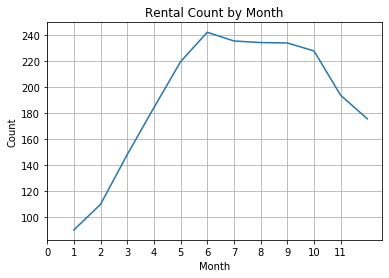

In [23]:
plt.plot(average_by_month.index,average_by_month)
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(np.arange(12))
plt.grid(True)
plt.title('Rental Count by Month')

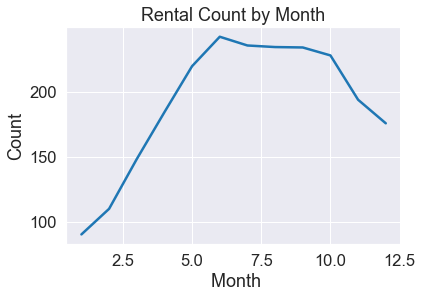

In [40]:
sb.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax=sb.lineplot(average_by_month.index,average_by_month)
ax.set(xlabel=" Month", ylabel="Count", title="Rental Count by Month")
plt.show()

# Comments:
We can see that from January to April, the demand is relatively low due to Winter (there are not a lot of people that's brave enough to bike on icy road, are there?). And the peak demand happends around Summer time (from May to October) and drop again.
This is definitely not a linear regression problem.

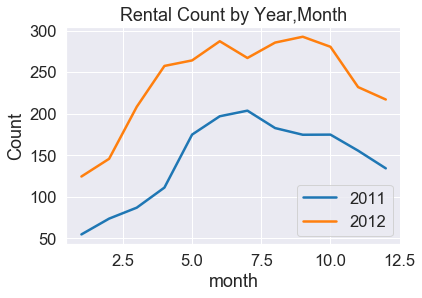

In [43]:
sb.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})


group_year_month = df.groupby(['year','month'])
average_year_month = group_year_month['count'].mean()
for year in average_year_month.index.levels[0]:
    #print (year)
    #print(average_year_month[year])
    #plt.plot(average_year_month[year].index,average_year_month[year],label=year)
    sb.lineplot(average_year_month[year].index,average_year_month[year],label=year)


    
plt.legend()    
plt.xlabel('month')
plt.ylabel('Count')
#plt.grid(True)
plt.title('Rental Count by Year,Month')
plt.show()

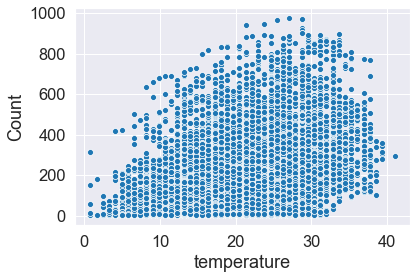

In [55]:
ax=sb.scatterplot(x=df.temp,y=df["count"])
ax.set(xlabel="temperature", ylabel="Count")

# plt.grid(True)
# plt.xlabel('Temperature')
# plt.ylabel('Count')
plt.show()

[xgboost_cloud_training_template.ipynb](https://github.com/tule2236/DemandForecasting-SageMaker/blob/master/xgboost_cloud_training_template.ipynb)

In [57]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

In [58]:
column_list_file = 'bike_train_column_list.txt'
train_file = 'bike_train.csv'
validation_file = 'bike_validation.csv'
test_file = 'bike_test.csv'

In [60]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'dayofweek'],
      dtype='object')

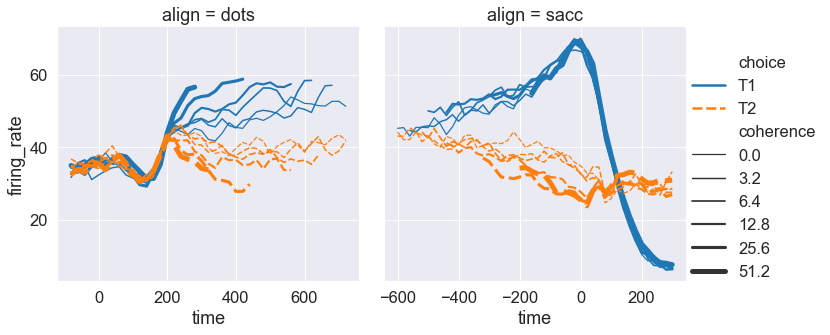

In [47]:
dots = sb.load_dataset("dots")
sb.relplot(x="time", y="firing_rate", col="align",
            hue="choice", size="coherence", style="choice",
            facet_kws=dict(sharex=False),
            kind="line", legend="full", data=dots);

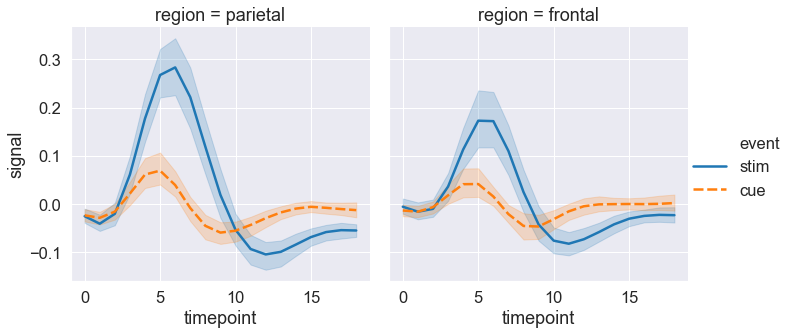

In [50]:
fmri = sb.load_dataset("fmri")
sb.relplot(x="timepoint", y="signal", col="region",
            hue="event", style="event",
            kind="line", data=fmri);

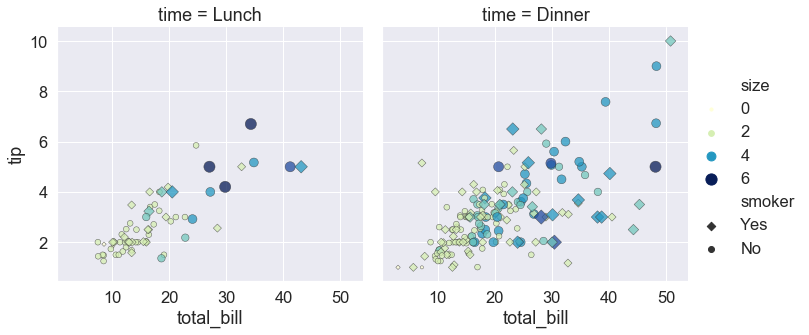

In [54]:

sb.relplot(x="total_bill", y="tip", col="time",
            hue="size", style="smoker", size="size",
            palette="YlGnBu", markers=["D", "o"], sizes=(10, 125),
            edgecolor=".2", linewidth=.5, alpha=.75,
            data=sb.load_dataset("tips"));